# Problem definition

## Airbnb Price Prediction with Machine Learning



**Airbnb** is a marketplace for short-term rentals that allows hosts to list part or all of their living space for others to book. The platform includes everything from private rooms to entire houses. Thanks to its flexibility and competitive prices, Airbnb has become one of the main alternatives to hotels worldwide. Since its founding in 2008, the company has grown exponentially: it went public in December 2020 with a valuation of about **\$47 billion**, and as of 2025 its market capitalization exceeds **\$85 billion**, making it more valuable than most global hotel chains.



### The Pricing Challenge

One of the biggest challenges for hosts is setting the optimal nightly price. In many cities, travelers are presented with a wide variety of listings and can filter by criteria such as:

- price  
- number of bedrooms  
- property type  
- location  

Because Airbnb is a competitive marketplace, the amount a host can charge is directly tied to supply and demand dynamics.  

- If a host sets a price much higher than the local average, guests will likely choose cheaper but similar alternatives.  
- If the price is set too low, the host loses potential revenue.  




### A Simple Strategy



A straightforward approach to pricing could be:  

1. Identify similar listings.  
2. Compute the average price among them.  
3. Use that value as a reference price.  

While simple, this strategy does not fully capture the complexity of the marketplace.




### Machine Learning for Price Prediction



The process of using existing data to predict future outcomes is called machine learning. In our case, we want to use local listing data to predict the ideal nightly rate.  

In this lesson, we will explore a **regularized linear regression model** (implemented in the [mlops repository](https://github.com/ivanovitchm/mlops)).  

This model fits a mathematical function to the available data, capturing relationships between multiple features—such as number of bedrooms, location, and property type—and estimating their impact on the final price. Unlike simple averaging strategies, regression provides a more systematic way to generalize and make robust predictions across different scenarios.  




### Next Step



Before diving deeper into the model, let’s first become familiar with the dataset we’ll be working with.


# Introduction to the data


While AirBnB does not release official data on the listings available in their marketplace, an independent initiative called [Inside AirBnB](https://insideairbnb.com/rio-de-janeiro/) has extracted and published data on a sample of listings for many major cities featured on the platform.  

In this lesson, we will work with their dataset from **March 2025**, focusing on the listings from **Rio de Janeiro, Brazil**, the world-renowned capital of Samba. Here is a [direct link to the dataset](https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz). Each row in this dataset corresponds to a specific property available for short-term rental on AirBnB in Rio de Janeiro.

To make the dataset easier to manage, we have removed many of the original 100+ columns. Below are the selected columns we will keep for our analysis:

- **host_response_rate**: the response rate of the host  
- **host_acceptance_rate**: percentage of requests to the host that convert into rentals  
- **host_listings_count**: number of other listings managed by the host  
- **latitude**: latitude of the property’s geographic coordinates  
- **longitude**: longitude of the property’s geographic coordinates  
- **city**: the city where the property is located  
- **zipcode**: the postal code of the property  
- **state**: the state where the property is located  
- **accommodates**: the number of guests the property can host  
- **room_type**: the type of accommodation (Private room, Shared room, or Entire home/apt)  
- **bedrooms**: number of bedrooms included in the rental  
- **bathrooms**: number of bathrooms available  
- **beds**: number of beds included  
- **price**: nightly rental price  
- **cleaning_fee**: additional fee charged for cleaning after the guest’s stay  
- **security_deposit**: refundable security deposit in case of damages  
- **minimum_nights**: minimum number of nights required for a booking  
- **maximum_nights**: maximum number of nights allowed for a booking  
- **number_of_reviews**: total number of reviews left by past guests  

Let’s load this dataset into Pandas and begin exploring it in more detail.


In [81]:
# Use wget to download the dataset
!wget -O listings.csv.gz "https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz"

# Unzip the .gz file (-k keeps the original .gz file)
!gunzip -k listings.csv.gz

--2025-09-24 01:17:43--  https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 18.165.98.33, 18.165.98.12, 18.165.98.100, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|18.165.98.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21857120 (21M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  20.84M  19.5MB/s    in 1.1s    

2025-09-24 01:17:45 (19.5 MB/s) - ‘listings.csv.gz’ saved [21857120/21857120]

gzip: listings.csv already exists; do you wish to overwrite (y or n)? y


In [82]:
# Now you have the "listings.csv" file available in Colab
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv("listings.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2302715,https://www.airbnb.com/rooms/2302715,20250319150537,2025-03-20,city scrape,guilherme,"House with five large bedrooms, living room, g...",NaN,https://a0.muscache.com/pictures/30842883/b19c...,11706874,https://www.airbnb.com/users/show/11706874,Guilherme,2014-01-27,"Rio, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/11706874/prof...,https://a0.muscache.com/im/users/11706874/prof...,NaN,2.0,2.0,"['email', 'phone']",t,f,NaN,Anil,NaN,-22.95221,-43.32944,Entire home,Entire home/apt,12,5.0,5 baths,5.0,10.0,"[""Washer"", ""Hot tub"", ""Breakfast"", ""TV with st...","$2,700.00",10,30,10,10,30,30,10.0,30.0,NaN,t,30,60,90,365,2025-03-20,0,0,0,287,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1,2304688,https://www.airbnb.com/rooms/2304688,20250319150537,2025-03-20,city scrape,OLIMPÍADAS 2016,"Apartment with living room, 2 bedrooms and kit...","Beaches, restaurants, supermarkets, amusement ...",https://a0.muscache.com/pictures/30867360/fe14...,10405816,https://www.airbnb.com/users/show/10405816,Eurico,2013-12-03,"Rio de Janeiro, Brazil",NaN,NaN,NaN,0%,f,https://a0.muscache.com/im/users/10405816/prof...,https://a0.muscache.com/im/users/10405816/prof...,NaN,1.0,1.0,"['email', 'phone']",t,f,"Rio, Rio de Janeiro, Brazil",Ipanema,NaN,-22.98767,-43.18991,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,3.0,"[""Washer"", ""TV with standard cable"", ""Wifi"", ""...",$837.00,7,14,7,7,14,14,7.0,14.0,NaN,t,30,60,90,365,2025-03-20,0,0,0,287,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
2,2306547,https://www.airbnb.com/rooms/2306547,20250319150537,2025-03-20,city scrape,Amplo Apto com 3 Dormitórios em Copacabana - 1...,Excellent apartment in Copacabana. Cozy and la...,The Copacabana Neighborhood is independent an...,https://a0.muscache.com/pictures/4923e99d-7190...,4107346,https://www.airbnb.com/users/show/4107346,Vera Lucia,2012-11-09,"Rio de Janeiro, Brazil",Sou uma pessoa que adora receber turistas no R...,within a few hours,100%,62%,f,https://a0.muscache.com/im/users/4107346/profi...,https://a0.muscache.com/im/users/4107346/profi...,Copacabana,1.0,1.0,"['email', 'phone']",t,t,"Copacabana, Rio de Janeiro, Brazil",Copacabana,NaN,-22.97333,-43.18857,Entire rental unit,Entire home/apt,7,2.0,2 baths,3.0,6.0,"[""Dedicated workspace"", ""Dishes and silverware...",$800.00,5,90,5,5,90,90,5.0,90.0,NaN,t,25,47,77,257,2025-03-20,13,3,1,257,4,30,24000.0,2020-01-07,2025-03-05,5.00,5.00,4.92,5.00,4.92,5.00,4.77,NaN,f,1,1,0,0,0.21
3,2306767,https://www.airbnb.com/rooms/2306767,20250319150537,2025-03-20,city scrape,Studio 

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42013 entries, 0 to 42012
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            42013 non-null  int64  
 1   listing_url                                   42013 non-null  object 
 2   scrape_id                                     42013 non-null  int64  
 3   last_scraped                                  42013 non-null  object 
 4   source                                        42013 non-null  object 
 5   name                                          42013 non-null  object 
 6   description                                   40982 non-null  object 
 7   neighborhood_overview                         16819 non-null  object 
 8   picture_url                                   42013 non-null  object 
 9   host_id                                       42013 non-null 

In [84]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.201300e+04,4.201300e+04,4.201300e+04,42008.000000,42008.000000,0.0,42013.000000,42013.000000,42013.000000,38313.000000,41373.000000,38335.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,0.0,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,42013.000000,3.835600e+04,33140.000000,33139.000000,33140.000000,33139.000000,33139.000000,33139.000000,33139.000000,0.0,42013.000000,42013.000000,42013.000000,42013.000000,33140.000000
mean,7.444710e+17,2.025032e+13,2.256052e+08,14.052466,24.933775,NaN,-22.966277,-43.248424,3.959394,1.497834,1.522297,2.357454,3.609526,366.076738,3.335920,4.209340,452.462071,480.008950,3.653403,463.654781,NaN,17.359175,36.676672,59.122367,188.777878,23.684859,8.113965,0.981268,161.185157,6.993169,49.724823,2.076935e+04,4.802137,4.816212,4.768009,4.886694,4.879855,4.857481,4.719113,NaN,9.338990,8.446433,0.777997,0.110156,1.263767
std,5.391705e+17,1.367985e+01,2.103432e+08,65.168438,141.331902,NaN,0.035432,0.100336,2.273275,0.971862,1.022382,2.116851,14.249756,379.761816,12.611217,14.462273,428.464379,436.574343,12.928592,426.924469,NaN,11.403082,21.049260,30.761915,128.669915,45.877236,12.482438,1.387351,101.939147,12.096823,69.011854,5.803371e+04,0.389698,0.381337,0.424701,0.313860,0.324846,0.318360,0.432712,NaN,24.426124,24.239087,2.130291,1.194582,1.277616
min,1.787800e+04,2.025032e+13,3.607000e+03,1.000000,1.000000,NaN,-23.073830,-43.723009,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,4.625830e+07,2.025032e+13,3.500060e+07,1.000000,1.000000,NaN,-22.984390,-43.300392,2.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,2.000000,80.000000,89.000000,1.500000,89.000000,NaN,6.000000,19.000000,39.000000,76.000000,1.000000,0.000000,0.000000,72.000000,0.000000,0.000000,0.000000e+00,4.760000,4.790000,4.710000,4.890000,4.890000,4.840000,4.660000,NaN,1.000000,1.000000,0.000000,0.000000,0.320000
50%,9.494565e+17,2.025032e+13,1.501449e+08,2.000000,3.000000,NaN,-22.971860,-43.193719,4.000000,1.000000,1.000000,2.000000,2.000000,365.000000,2.000000,3.000000,365.000000,365.000000,2.000000,365.000000,NaN,20.000000,42.000000,70.000000,173.000000,6.000000,2.000000,0.000000,167.000000,1.000000,18.000000,6.156000e+03,4.920000,4.930000,4.900000,5.000000,5.000000,4.960000,4.830000,NaN,2.000000,1.000000,0.000000,0.000000,0.930000
75%,1.236132e+18,2.025032e+13,4.149635e+08,6.000000,9.000000,NaN,-22.952710,-43.184728,5.000000,2.000000,2.000000,3.000000,3.000000,365.000000,3.000000,4.000000,1125.000000,1125.000000,3.000000,1125.000000,NaN,29.000000,56.000000,86.000000,329.000000,26.000000,11.000000,2.000000,268.000000,9.000000,72.000000,2.416050e+04,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,5

In [85]:
df.duplicated().sum()

np.int64(0)

In [86]:
df.shape

(42013, 79)

# Clean, Prepare & Manipulate Data

In [87]:
# Remove commas from the 'price' column (e.g., "$1,200" → "$1200")
stripped_commas = df['price'].str.replace(',', '')

# Remove dollar signs from the 'price' column (e.g., "$1200" → "1200")
stripped_dollars = stripped_commas.str.replace('$', '')

# Convert the cleaned 'price' column from string to float type
df['price'] = stripped_dollars.astype('float')

In [88]:
# Remove any rows containing missing values across the selected columns
#df.dropna(axis=0, inplace=True)
df.dropna(subset=['price'], inplace=True)

In [89]:
numeric_df = df.select_dtypes(include=["number", "float", "int"])
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38356 entries, 0 to 42012
Data columns (total 46 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            38356 non-null  int64  
 1   scrape_id                                     38356 non-null  int64  
 2   host_id                                       38356 non-null  int64  
 3   host_listings_count                           38352 non-null  float64
 4   host_total_listings_count                     38352 non-null  float64
 5   neighbourhood_group_cleansed                  0 non-null      float64
 6   latitude                                      38356 non-null  float64
 7   longitude                                     38356 non-null  float64
 8   accommodates                                  38356 non-null  int64  
 9   bathrooms                                     38313 non-null  floa

In [90]:
numeric_df = numeric_df.drop(columns=[
    "license",
    "calendar_updated",
    "neighbourhood_group_cleansed",
    "id",
    "scrape_id",
    "host_id",
    "host_listings_count",
    "host_total_listings_count"
])
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38356 entries, 0 to 42012
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      38356 non-null  float64
 1   longitude                                     38356 non-null  float64
 2   accommodates                                  38356 non-null  int64  
 3   bathrooms                                     38313 non-null  float64
 4   bedrooms                                      38304 non-null  float64
 5   beds                                          38335 non-null  float64
 6   price                                         38356 non-null  float64
 7   minimum_nights                                38356 non-null  int64  
 8   maximum_nights                                38356 non-null  int64  
 9   minimum_minimum_nights                        38356 non-null  int6

In [91]:
numeric_df = numeric_df.dropna(axis=0)
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30292 entries, 2 to 41946
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      30292 non-null  float64
 1   longitude                                     30292 non-null  float64
 2   accommodates                                  30292 non-null  int64  
 3   bathrooms                                     30292 non-null  float64
 4   bedrooms                                      30292 non-null  float64
 5   beds                                          30292 non-null  float64
 6   price                                         30292 non-null  float64
 7   minimum_nights                                30292 non-null  int64  
 8   maximum_nights                                30292 non-null  int64  
 9   minimum_minimum_nights                        30292 non-null  int6

In [92]:
numeric_df.isnull().sum()

,0
latitude,0
longitude,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0
price,0
minimum_nights,0
maximum_nights,0
minimum_minimum_nights,0


In [93]:
corr_matrix = numeric_df.corr(method="pearson")
corr_matrix

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
latitude,1.000000,0.391921,-0.136537,-0.148409,-0.139486,-0.081675,-0.032942,-0.018486,-0.001693,-0.018634,-0.014700,0.006357,-0.007137,-0.020145,0.000926,0.036332,0.017582,0.009697,0.023502,-0.049547,-0.021223,0.016397,0.017752,-0.027864,-0.036871,-0.106677,0.015844,0.022387,0.029547,0.003365,0.016470,-0.124475,0.025307,-0.062079,-0.075895,0.128807,0.059398,0.024581
longitude,0.391921,1.000000,-0.107856,-0.097199,-0.116266,-0.080291,0.000789,0.015518,-0.057788,0.013923,0.031238,-0.046712,-0.030399,0.023272,-0.043304,-0.178347,-0.204768,-0.179607,-0.124876,0.083090,0.076193,0.102631,-0.125728,0.071102,0.092899,0.045805,0.011227,0.027651,0.012718,0.033971,0.009650,0.100891,0.001307,0.052213,0.051106,0.011418,0.012743,0.075442
accommodates,-0.136537,-0.107856,1.000000,0.572179,0.647848,0.680254,0.094711,0.008074,0.052779,0.013334,0.010925,0.034911,0.050695,0.011064,0.038181,0.008859,0.021412,0.029945,0.074992,0.005535,-0.004686,-0.033542,0.076217,0.000679,-0.001780,0.178663,-0.023896,-0.038846,-0.044555,-0.014055,-0.013944,-0.011278,-0.022130,0.069754,0.081517,-0.143944,0.028883,-0.029326
bathrooms,-0.148409,-0.097199,0.572179,1.000000,0.683880,0.531902,0.113558,0.030034,0.037463,0.034571,0.025422,0.002257,0.008447,0.034275,0.003172,0.016850,0.024710,0.023748,0.068114,-0.039150,-0.081345,-0.088670,0.064021,-0.068486,-0.076408,0.176378,0.006964,-0.009619,-0.021658,-0.008963,-0.013257,0.016114,-0.002550,0.042293,0.042244,-0.013433,0.039463,-0.118671
bedrooms,-0.139486,-0.116266,0.647848,0.683880,1.000000,0.560463,0.108686,0.028954,0.035333,0.037776,0.021346,-0.003506,0.002036,0.033107,-0.003535,0.008390,0.012795,0.012398,0.072251,-0.059654,-0.085025,-0.091264,0.065114,-0.074899,-0.078065,0.171535,-0.022939,-0.036855,-0.037809,-0.023638,-0.031365,-0.005360,-0.027933,0.049582,0.056562,-0.062506,-0.031659,-0.114649
beds,-0.081675,-0.080291,0.680254,0.531902,0.560463,1.000000,0.066152,0.014423,0.054306,0.019489,0.010392,0.038876,0.050128,0.015997,0.041965,0.018375,0.022369,0.027493,0.064433,0.014890,-0.026504,-0.047053,0.063551,-0.014681,-0.021735,0.127822,-0.016452,-0.033011,-0.035916,-0.021316,-0.013756,-0.010565,-0.010299,0.039002,0.039847,-0.063416,0.127293,-0.064954
price,-0.032942,0.000789,0.094711,0.113558,0.108686,0.066152,1.000000,0.018440,-0.001795,0.022537,0.014469,-0.009434,-0.010387,0.019870,-0.010163,0.020262,0.024288,0.020060,0.027019,-0.023891,-0.036298,-0.038711,0.024764,-0.031390,-0.038285,0.166712,-0.001081,-0.007816,-0.005021,0.002105,-0.007348,0.009490,-0.009129,0.004468,0.006727,-0.021028,-0.010846,-0.042737
minimum_nights,-0.018486,0.015518,0.008074,0.030034,0.028954,0.014423,0.018440,1.000000,0.011500,0.873422,0.689435,0.010418,-0.000308,0.916193,0.006822,-0.028247,-0.026623,-0.026545,-0.000790,-0.021161,-0.062836,-0.070765,-0.007012,-0.050662,0.013140,0.016118,-0.003286,-0.004746,-0.012318,0.004253,0.004970,0.001150,-0.013965,-0.026423,-0.024593,-0.016520,-0.014640,-0.081261
maximum_nights,-0.001693,-0.057788,0.052779,0.037463,0.035333,0.054306,-0.001795,0.011500,1.000000,0.017531,0.016794,0.685860,0.675445,0.013758,0.687924,-0.008492,-0.008581,0.000366,0.155503,0.079517,0.002487,-0.032074,0.138320,0.020763,-0.006689,-0.009210,-0.039

In [94]:
corr_with_price = corr_matrix["price"].sort_values(ascending=False)
print(corr_with_price)

price                                           1.000000
estimated_revenue_l365d                         0.166712
bathrooms                                       0.113558
bedrooms                                        0.108686
accommodates                                    0.094711
beds                                            0.066152
availability_365                                0.027019
availability_eoy                                0.024764
availability_60                                 0.024288
minimum_minimum_nights                          0.022537
availability_30                                 0.020262
availability_90                                 0.020060
minimum_nights_avg_ntm                          0.019870
minimum_nights                                  0.018440
maximum_minimum_nights                          0.014469
review_scores_location                          0.009490
calculated_host_listings_count_entire_homes     0.006727
calculated_host_listings_count 

In [129]:
# Select only the relevant columns from the original dataframe 'df'
# These columns include property features (e.g., accommodates, bathrooms, bedrooms)
# and booking information (e.g., minimum_nights, maximum_nights, number_of_reviews, price).

target_columns = [
    "accommodates",      # Number of guests the property can host
    "bathrooms",         # Number of bathrooms available
    "bedrooms",          # Number of bedrooms available
    "beds",              # Number of beds available
    "minimum_nights",    # Minimum nights required for a booking
    "review_scores_value",
    "estimated_occupancy_l365d",
    "number_of_reviews", # Total reviews given by past guests
    "price"              # Nightly rental price
]

# Create a new dataframe called 'rio_listings' with only the selected columns
# Using .copy() ensures that we are working with an independent dataframe
# instead of just a view of the original data.

rio_listings = df[target_columns].copy()

# Display a five rows sample of the new dataframe to quickly check the data
rio_listings.sample(5)

,accommodates,bathrooms,bedrooms,beds,minimum_nights,review_scores_value,estimated_occupancy_l365d,number_of_reviews,price
8724,1,1.0,1.0,2.0,4,5.00,0,1,176.0
22360,2,1.5,1.0,1.0,1,4.60,18,5,81.0
3217,2,1.0,1.0,1.0,2,4.92,60,38,106.0
23092,4,1.5,1.0,1.0,1,NaN,0,0,250.0
6002,8,2.0,1.0,2.0,1,NaN,0,0,2700.0


In [130]:
# Generate descriptive statistics
rio_listings.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,review_scores_value,estimated_occupancy_l365d,number_of_reviews,price
count,38356.000000,38313.000000,38304.000000,38335.000000,38356.000000,30355.000000,38356.000000,38356.000000,38356.000000
mean,3.978074,1.497834,1.514724,2.357454,3.477031,4.723180,51.314996,24.419595,720.284832
std,2.296634,0.971862,1.022828,2.116851,13.625035,0.421719,69.808647,46.638295,4165.194984
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,30.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,4.670000,0.000000,1.000000,220.000000
50%,4.000000,1.000000,1.000000,2.000000,2.000000,4.830000,18.000000,6.000000,343.000000
75%,5.000000,2.000000,2.000000,3.000000,3.000000,5.000000,72.000000,27.000000,600.000000
max,16.000000,20.000000,27.000000,56.000000,1000.000000,5.000000,255.000000,726.000000,500000.000000


In [131]:
# Check missing values
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38356 entries, 0 to 42012
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               38356 non-null  int64  
 1   bathrooms                  38313 non-null  float64
 2   bedrooms                   38304 non-null  float64
 3   beds                       38335 non-null  float64
 4   minimum_nights             38356 non-null  int64  
 5   review_scores_value        30355 non-null  float64
 6   estimated_occupancy_l365d  38356 non-null  int64  
 7   number_of_reviews          38356 non-null  int64  
 8   price                      38356 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 2.9 MB


## Robust IQR-based outlier filtering


In [132]:
def _iqr_bounds(series: pd.Series, k: float = 1.5):
    """
    Compute lower/upper bounds for outlier detection using the IQR rule.

    Parameters
    ----------
    series : pd.Series
        Numeric series.
    k : float, default 1.5
        Whisker length multiplier (1.5 = Tukey; 3.0 = more tolerant).

    Returns
    -------
    low : float
        Lower bound (Q1 - k * IQR).
    up : float
        Upper bound (Q3 + k * IQR).
    stats : dict
        Dict with Q1, Q3, IQR.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    up = q3 + k * iqr
    return low, up, {"Q1": q1, "Q3": q3, "IQR": iqr}


def remove_outliers_iqr(
    df: pd.DataFrame,
    columns: list[str],
    k: float = 1.5,
    inclusive: bool = True,
    dropna: bool = True,
):
    """
    Remove rows with outliers per-column using the IQR rule.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str
        Columns to evaluate for outliers (must be numeric or coercible).
    k : float, default 1.5
        Whisker length multiplier (1.5 = standard; 3.0 = lenient).
    inclusive : bool, default True
        If True, keep values exactly on the bounds; otherwise use strict inequality.
    dropna : bool, default True
        If True, drop rows with NaN in the selected columns prior to filtering.

    Returns
    -------
    cleaned : pd.DataFrame
        DataFrame with outlier rows removed.
    info : dict
        Summary with input/output row counts and per-column bounds/statistics.
    """
    data = df.copy()

    # Ensure columns are numeric; non-numeric values become NaN
    for c in columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    # Optionally drop NaNs first to avoid excluding entire rows by comparison
    if dropna:
        data = data.dropna(subset=columns)

    before = len(data)
    bounds = {}
    # Start with all rows valid; refine with each column's mask
    mask = pd.Series(True, index=data.index)

    for c in columns:
        low, up, stats = _iqr_bounds(data[c].dropna(), k=k)
        bounds[c] = {"low": low, "up": up, **stats}

        if inclusive:
            m = (data[c] >= low) & (data[c] <= up)
        else:
            m = (data[c] > low) & (data[c] < up)

        mask &= m

    cleaned = data.loc[mask].copy()
    info = {
        "rows_in": before,
        "rows_out": len(cleaned),
        "rows_removed": before - len(cleaned),
        "k": k,
        "inclusive": inclusive,
        "bounds": bounds,
    }
    return cleaned, info

In [133]:
# Assumes you already have:
# - df (your full dataset)
# - target_columns = ["accommodates","bathrooms","bedrooms","beds","minimum_nights",
#                     "maximum_nights","number_of_reviews","price"]
# - rio_listings = df[target_columns].copy()   # your prepared subset

# Copy the dataset to work on IQR filtering
#rio_iqr_input = rio_listings[target_columns].copy()
rio_iqr_input = rio_listings.copy()
# Remove outliers with default Tukey rule (k=1.5) and inclusive bounds
rio_iqr, summary = remove_outliers_iqr(
    df=rio_iqr_input,
    columns=target_columns,
    k=1.5,
    inclusive=True,
    dropna=True,
)

print(f"Rows before:  {summary['rows_in']}")
print(f"Rows after:   {summary['rows_out']}")
print(f"Removed:      {summary['rows_removed']}")
print("Per-column bounds (low/up):")
for col, b in summary["bounds"].items():
    print(f"  - {col}: [{b['low']:.3f}, {b['up']:.3f}]  (Q1={b['Q1']:.3f}, Q3={b['Q3']:.3f}, IQR={b['IQR']:.3f})")

rio_iqr.head()

Rows before:  30293
Rows after:   20929
Removed:      9364
Per-column bounds (low/up):
  - accommodates: [-2.500, 9.500]  (Q1=2.000, Q3=5.000, IQR=3.000)
  - bathrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - bedrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - beds: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - minimum_nights: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - review_scores_value: [4.175, 5.495]  (Q1=4.670, Q3=5.000, IQR=0.330)
  - estimated_occupancy_l365d: [-119.000, 225.000]  (Q1=10.000, Q3=96.000, IQR=86.000)
  - number_of_reviews: [-46.500, 85.500]  (Q1=3.000, Q3=36.000, IQR=33.000)
  - price: [-257.000, 991.000]  (Q1=211.000, Q3=523.000, IQR=312.000)


,accommodates,bathrooms,bedrooms,beds,minimum_nights,review_scores_value,estimated_occupancy_l365d,number_of_reviews,price
2,7,2.0,3.0,6.0,5,4.77,30,13,800.0
4,4,1.0,1.0,2.0,2,4.75,24,28,220.0
5,2,1.0,1.0,1.0,2,4.89,48,36,401.0
7,4,2.0,2.0,2.0,3,4.95,66,38,399.0
8,4,1.0,1.0,2.0,4,5.00,0,3,198.0


In [134]:
rio_iqr.price.describe()

,price
count,20929.000000
mean,349.933776
std,197.258810
min,41.000000
25%,204.000000
50%,299.000000
75%,450.000000
max,991.000000


## Correlation Heatmap of Rio Listings Features

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise correlation matrix using Pearson's correlation coefficient
corr_matrix = rio_iqr.corr(method="pearson")

# Display features sorted by correlation strength with the target ('price')
# This helps identify which features are most relevant to predict 'price'
price_corr = corr_matrix["price"].sort_values(ascending=False)

print("Correlation of features with target 'price':\n")
print(price_corr)

Correlation of features with target 'price':

price                        1.000000
bedrooms                     0.436194
bathrooms                    0.410929
accommodates                 0.393066
beds                         0.300597
minimum_nights               0.150523
review_scores_value         -0.000618
number_of_reviews           -0.053668
estimated_occupancy_l365d   -0.088784
Name: price, dtype: float64


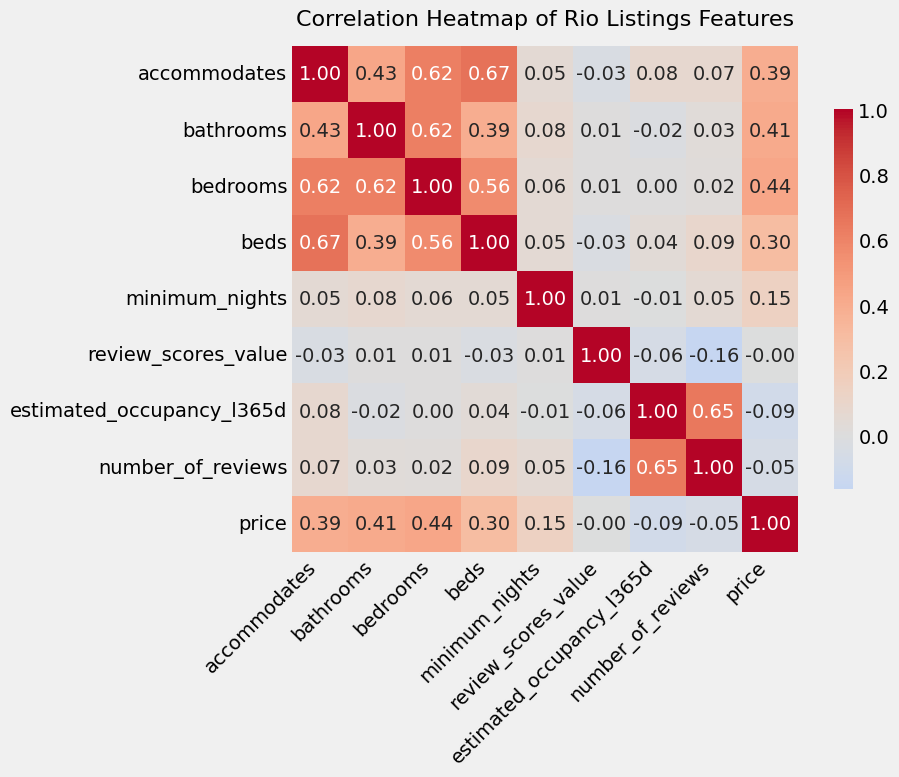

In [136]:
# Visualize correlation matrix

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,          # show correlation values
    fmt=".2f",           # format with 2 decimals
    cmap="coolwarm",     # colormap: negative=blue, positive=red
    center=0,            # center color scale at 0
    square=True,         # square cells
    cbar_kws={"shrink": 0.75}  # adjust colorbar size
)

# Add a title to the heatmap
plt.title("Correlation Heatmap of Rio Listings Features", fontsize=16, pad=15)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# End-to-End Solution Pipeline in PyTorch

## Import

In [137]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
plt.style.use('fivethirtyeight')

## Architecture class

In [138]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Data Preparation

In [139]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20929 entries, 2 to 41943
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               20929 non-null  int64  
 1   bathrooms                  20929 non-null  float64
 2   bedrooms                   20929 non-null  float64
 3   beds                       20929 non-null  float64
 4   minimum_nights             20929 non-null  int64  
 5   review_scores_value        20929 non-null  float64
 6   estimated_occupancy_l365d  20929 non-null  int64  
 7   number_of_reviews          20929 non-null  int64  
 8   price                      20929 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.6 MB


In [140]:
# ---------------------------------------------------------------------
# 1) Extract features (X) and target (y) from the DataFrame
# ---------------------------------------------------------------------

# Keep all numeric feature columns except the target 'price'
feature_cols = [c for c in rio_iqr.columns if c != "price"]
target_col   = "price"

# Convert to NumPy arrays (float32 is ideal for PyTorch)
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)     # shape (N, D)
y = rio_iqr[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)  # shape (N, 1)

# Quick sanity checks
assert not np.isnan(X).any(), "Found NaNs in X. Clean/impute before training."
assert not np.isnan(y).any(), "Found NaNs in y. Clean/impute before training."

In [141]:
# ---------------------------------------------------------------------
# 2) Build tensors BEFORE splitting (as you requested)
# ---------------------------------------------------------------------

torch.manual_seed(13)

x_tensor = torch.as_tensor(X).float()   # (N, D)
y_tensor = torch.as_tensor(y).float()   # (N, 1)

# Whole dataset
dataset = TensorDataset(x_tensor, y_tensor)

In [142]:
# ---------------------------------------------------------------------
# 3) Train/validation split using PyTorch's random_split
# ---------------------------------------------------------------------
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val   = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

In [ ]:
type(train_data)

torch.utils.data.dataset.Subset

In [ ]:
type(val_data)

torch.utils.data.dataset.Subset

In [143]:
# ---------------------------------------------------------------------
# Z-score without leakage
# ---------------------------------------------------------------------
from torch.utils.data import Subset

# 0) Get split indices produced by random_split (already done above)
train_idx = train_data.indices
val_idx   = val_data.indices

# 1) Compute mean/std ONLY on training subset
eps = 1e-8
mu  = x_tensor[train_idx].mean(dim=0)
std = x_tensor[train_idx].std(dim=0, unbiased=False)
std = torch.where(std < eps, torch.ones_like(std), std)  # avoid divide-by-zero

y_mu  = y_tensor[train_idx].mean(dim=0)
y_std = y_tensor[train_idx].std(dim=0, unbiased=False)
y_std = torch.where(y_std < eps, torch.ones_like(y_std), y_std)


# 2) Apply z-score to ALL features using training stats
x_tensor_z = (x_tensor - mu) / std
y_tensor_z = (y_tensor - y_mu) / y_std


# 3) Rebuild dataset with normalized features and REUSE the SAME indices
dataset_z  = TensorDataset(x_tensor_z, y_tensor_z)
train_data = Subset(dataset_z, train_idx)
val_data   = Subset(dataset_z, val_idx)

# Modificação da normalização para a escala Min-Máx usando Gemini
Prompt:"modifique o codigo de normalização para a escala Min-Máx"

In [ ]:
# ---------------------------------------------------------------------
# Min-Max normalization without leakage
# ---------------------------------------------------------------------
from torch.utils.data import Subset

# 0) Get split indices produced by random_split (assuming this was done previously)
# If not, you would need to perform the split here or in a preceding cell
train_idx = train_data.indices
val_idx   = val_data.indices

# 1) Compute min/max ONLY on training subset
x_min = x_tensor[train_idx].min(dim=0).values
x_max = x_tensor[train_idx].max(dim=0).values

y_min = y_tensor[train_idx].min(dim=0).values
y_max = y_tensor[train_idx].max(dim=0).values

# Avoid division by zero if min and max are the same
eps = 1e-8
x_range = x_max - x_min
x_range = torch.where(x_range < eps, torch.ones_like(x_range), x_range)

y_range = y_max - y_min
y_range = torch.where(y_range < eps, torch.ones_like(y_range), y_range)


# 2) Apply min-max normalization to ALL features using training stats
x_tensor_norm = (x_tensor - x_min) / x_range
y_tensor_norm = (y_tensor - y_min) / y_range


# 3) Rebuild dataset with normalized features and REUSE the SAME indices
dataset_norm  = TensorDataset(x_tensor_norm, y_tensor_norm)
train_data = Subset(dataset_norm, train_idx)
val_data   = Subset(dataset_norm, val_idx)

In [144]:
# 4) Recreate the DataLoaders
batch_size  = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False)

# Quick peek to confirm shapes
xb, yb = next(iter(train_loader))
print(f"Train batch X: {xb.shape} | y: {yb.shape}")  # e.g., (16, D) and (16, 1)

Train batch X: torch.Size([16, 8]) | y: torch.Size([16, 1])


## Model Configuration

In [145]:
# 5) (Optional but safer) Make model input dimension dynamic
# Sets learning rate
lr = 0.001
torch.manual_seed(42)
D = x_tensor.shape[1]  # number of features
model = nn.Sequential(nn.Linear(D, 1))
loss_fn = nn.MSELoss(reduction='mean')

In [146]:
# executar para a usar o otimizador SGD
optimizer = optim.SGD(model.parameters(), lr=lr)

In [118]:
# executar para usar o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

## Training

In [147]:
n_epochs = 100
arch = Architecture(model, loss_fn, optimizer)
arch.set_seed(42)
arch.set_loaders(train_loader, val_loader)
arch.train(n_epochs=n_epochs)

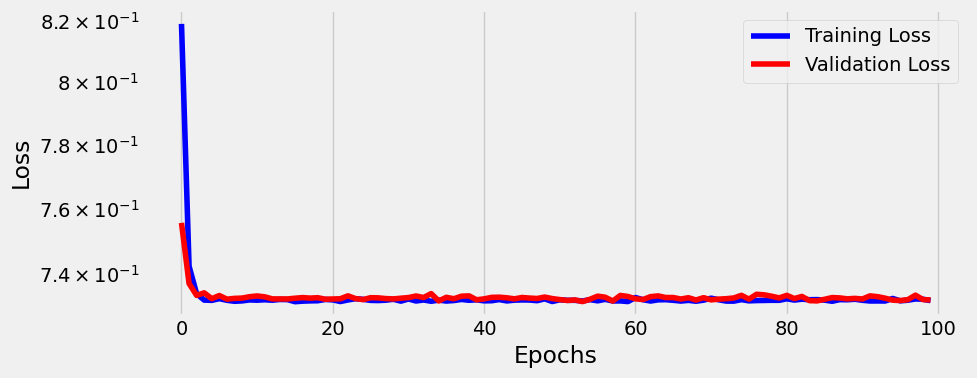

In [148]:
fig = arch.plot_losses()

In [149]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20929 entries, 2 to 41943
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               20929 non-null  int64  
 1   bathrooms                  20929 non-null  float64
 2   bedrooms                   20929 non-null  float64
 3   beds                       20929 non-null  float64
 4   minimum_nights             20929 non-null  int64  
 5   review_scores_value        20929 non-null  float64
 6   estimated_occupancy_l365d  20929 non-null  int64  
 7   number_of_reviews          20929 non-null  int64  
 8   price                      20929 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.6 MB


In [150]:
# -------------------------------------------------------------
# Suppose you trained and still have mu, std (for X) and y_mu, y_std (for y)
# -------------------------------------------------------------
# Example: one new sample with 7 features (same order as feature_cols)
X_new = np.array([[2.0, 1.0, 2.0, 2.0, 4.0, 5.0, 50.0, 30.0]], dtype=np.float32)
# (this is just a made-up input)

# -------------------------------------------------------------
# 1) Apply the SAME feature normalization (z-score using training mu/std)
# -------------------------------------------------------------
X_new_t = torch.as_tensor(X_new)
X_new_norm = (X_new_t - mu) / std  # mu, std from TRAIN only

# -------------------------------------------------------------
# 2) Predict with your trained Architecture
# -------------------------------------------------------------
y_pred_z = arch.predict(X_new_norm.numpy())   # prediction in standardized space of y

# -------------------------------------------------------------
# 3) Revert target normalization back to original units
# -------------------------------------------------------------
y_pred_real = y_pred_z * y_std.item() + y_mu.item()

# Convert to scalar
y_pred_real_value = float(y_pred_real.squeeze())

print(f"Predicted price: R$ {y_pred_real_value:.2f}")

Predicted price: R$ 358.58


# Modificação do código para privisão de novas entradas no modelo usando o Gemini
Prompt:"modifique o código para o uso da normalização Min-Máx"

In [ ]:
# -------------------------------------------------------------
# Suppose you trained and still have x_min, x_range, y_min, y_range (for Min-Max)
# -------------------------------------------------------------
# Example: one new sample with 7 features (same order as feature_cols)
X_new = np.array([[2.0, 1.0, 2.0, 2.0, 4.0, 5.0, 50.0, 30.0]], dtype=np.float32)
# (this is just a made-up input)

# -------------------------------------------------------------
# 1) Apply the SAME feature normalization (Min-Max using training min/max)
# -------------------------------------------------------------
X_new_t = torch.as_tensor(X_new)
X_new_norm = (X_new_t - x_min) / x_range  # x_min, x_range from TRAIN only (Min-Max)


# -------------------------------------------------------------
# 2) Predict with your trained Architecture
# -------------------------------------------------------------
y_pred_norm = arch.predict(X_new_norm.numpy())   # prediction in normalized space

# -------------------------------------------------------------
# 3) Revert target normalization back to original units
# -------------------------------------------------------------
y_pred_real = y_pred_norm * y_range.item() + y_min.item() # y_min, y_range from TRAIN only (Min-Max)


# Convert to scalar
y_pred_real_value = float(y_pred_real.squeeze())

print(f"Predicted price: R$ {y_pred_real_value:.2f}")

Predicted price: R$ 378.34


# Métricas para a avaliação do modelo usando o Gemini
Prompt: "
crie um codigo para avaliar o desempenho do modelo usando MSE, RMSE, MAE e R2. Assuma as duas formas de normalização."

In [151]:
# -------------------------------------------------------------
# Evaluate the model performance on the validation set
# -------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get the normalized validation data
val_x_tensor_norm = torch.as_tensor(val_data[:][0]).float()
val_y_tensor_norm = torch.as_tensor(val_data[:][1]).float()

# Predict on the validation set (in normalized space)
val_y_pred_norm = arch.predict(val_x_tensor_norm.numpy())

In [152]:
# Assuming Z-score normalization was used
val_y_true_real = val_y_tensor_norm.numpy() * y_std.item() + y_mu.item()
val_y_pred_real = val_y_pred_norm * y_std.item() + y_mu.item()
normalization_method = "Z-score"

In [ ]:
# Assuming Min-Max normalization was used
val_y_true_real = val_y_tensor_norm.numpy() * y_range.item() + y_min.item()
val_y_pred_real = val_y_pred_norm * y_range.item() + y_min.item()
normalization_method = "Min-Max"

In [153]:
if normalization_method != "Unknown":
    # Calculate MSE and RMSE on the real scale
    mse = mean_squared_error(val_y_true_real, val_y_pred_real)
    rmse = np.sqrt(mse)

    # Calculate MAE and R-squared on the real scale
    mae = mean_absolute_error(val_y_true_real, val_y_pred_real)
    r2 = r2_score(val_y_true_real, val_y_pred_real)

    print(f"Evaluation Metrics ({normalization_method} Normalization):")
    print(f"Mean Squared Error (MSE) on validation set: {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE) on validation set: {rmse:.2f}")
    print(f"Mean Absolute Error (MAE) on validation set: {mae:.2f}")
    print(f"R-squared (R2) on validation set: {r2:.2f}")

Evaluation Metrics (Z-score Normalization):
Mean Squared Error (MSE) on validation set: 28486.44
Root Mean Squared Error (RMSE) on validation set: 168.78
Mean Absolute Error (MAE) on validation set: 128.99
R-squared (R2) on validation set: 0.26
